In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
covid = pd.read_csv("Data/Covid Data/Medical_Examiner_Case_Archive_-_COVID-19_Related_Deaths.csv")
covidCases = pd.read_csv('Data/Covid Data/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv')
zip = pd.read_csv("Data/Zip_Codes.csv")
soc = pd.read_csv('Chicago Sociodemographics Zipcode.csv')

In [3]:
zipcodes = zip.ZIP.to_list()
zipcodes.remove(60666) #OHare Airport!!
covid = covid[covid['Residence Zip'].notna()]
sep = '-'
covid['Residence Zip'] = covid['Residence Zip'].apply(lambda x: x.split(sep, 1)[0])
covid['Residence Zip'] = covid['Residence Zip'].astype(str).astype(int)
covid = covid[covid['Residence Zip'].isin(zipcodes)]
covid['Date of Death'] = pd.to_datetime(covid['Date of Death'])
covid['Date of Death'] = covid['Date of Death'].dt.date
covid = covid[covid['Date of Death'] <= datetime.date(2022, 3, 5)]
covid = covid.sort_values(by=['Date of Death'])
covid = covid[(covid['Manner of Death']!='ACCIDENT') & (covid['Manner of Death']!='SUICIDE')]
covid = covid[covid['COVID Related'] == True]
covid = covid.rename(columns={"Residence Zip": "Zipcode"})

covid = covid.drop(['Case Number','Date of Incident','Manner of Death','Residence City', 'Primary Cause', 'Primary Cause Line A', 'Primary Cause Line B',
       'Primary Cause Line C', 'Secondary Cause', 'Gun Related', 'COVID Related', 'Opioid Related', 'Commissioner District',
       'Incident Address', 'Incident City', 'Incident Zip Code', 'longitude',
       'latitude', 'location', 'OBJECTID', 'Chicago Ward',
       'Chicago Community Area'],axis=1)

In [4]:
covidCases['Week Start'] = pd.to_datetime(covidCases['Week Start']).dt.date
covidCases['Week End'] = pd.to_datetime(covidCases['Week End']).dt.date
covidCases = covidCases[covidCases['Week End'] == datetime.date(2022, 3, 5)]
covidCases['Cases - Cumulative'] = covidCases['Cases - Cumulative'].apply(np.int64)
covidCases = covidCases[['ZIP Code', 'Cases - Cumulative']]
covidCases = covidCases[covidCases['ZIP Code'] != 'Unknown']
covidCases['ZIP Code'] = covidCases['ZIP Code'].astype(str).astype(int)
covidCases = covidCases[covidCases['ZIP Code'].isin(zipcodes)]
covidCases = covidCases.rename(columns={'ZIP Code': 'Zipcode'})
covidCases = covidCases.rename(columns={'Cases - Cumulative': 'Case Counts'})

In [5]:
deathCountByZip = covid.groupby('Zipcode').size().to_frame().reset_index().rename(columns={0: 'Death Counts'})

mergedSocCovid = pd.merge(soc, deathCountByZip, how='inner', on = 'Zipcode')
mergedSocCovid['Death Counts(Per 1000)'] = (mergedSocCovid['Death Counts'] / mergedSocCovid.Population) * 1000

mergedSocCovid = pd.merge(mergedSocCovid, covidCases, how='inner', on = 'Zipcode')
mergedSocCovid['Case Counts(Per 1000)'] = (mergedSocCovid['Case Counts'] / mergedSocCovid.Population) * 1000

mergedSocCovid = mergedSocCovid.round(2)

mergedSocCovid = mergedSocCovid.drop_duplicates()

In [6]:
mergedSocCovid.head()

,Zipcode,Population,Median age,Male(%),Female(%),White(%),Black(%),Native(%),Asian(%),Islander(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Death Counts,Death Counts(Per 1000),Case Counts,Case Counts(Per 1000)
0,60647,85658,32.2,49.75,50.25,48.50,4.72,0.02,3.96,0.01,...,14.76,14.11,1.67,0.68,66.31,2.47,184,2.15,17196,200.75
1,60639,88515,34.6,49.90,50.10,8.07,13.24,0.12,1.39,0.01,...,4.69,2.99,0.61,0.00,91.67,0.03,278,3.14,24130,272.61
2,60707,42434,40.0,47.33,52.67,46.85,6.63,0.19,3.31,0.00,...,42.45,11.93,0.98,0.00,44.29,0.34,130,3.06,4235,99.80
4,60622,52957,32.2,50.64,49.36,64.44,5.35,0.00,4.53,0.13,...,38.17,19.04,1.60,0.50,38.03,2.65,89,1.68,11074,209.11
5,60651,63679,33.9,46.37,53.63,5.00,53.02,0.11,0.28,0.00,...,1.55,2.46,0.89,0.00,94.89,0.21,182,2.86,14030,220.32


In [23]:
mergedSocCovid.to_csv('Chicago-Covid-SocioDemographics-Cases-Deaths.csv', index=False)

In [7]:
deathCountByDate = covid.groupby('Date of Death').size().to_frame().reset_index().rename(columns={0: 'Death Counts'})

Text(0.5, 0, 'Date')

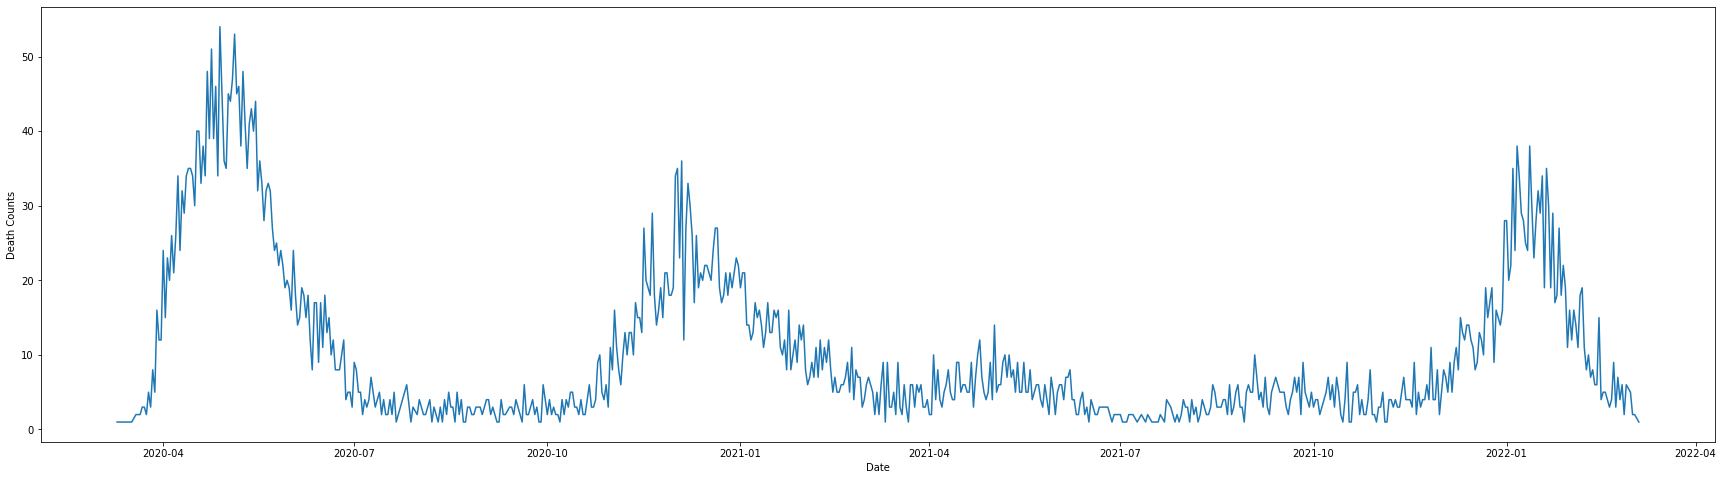

In [14]:
plt.figure(figsize=(30,8))
sns.lineplot(data=deathCountByDate, x="Date of Death", y="Death Counts")
plt.xlabel("Date")